In [2]:
from typing import Tuple, Dict

import pandas as pd
import numpy as np
import cv2
import pathlib
import pickle

from utils.vision.models import unet_model
from utils.callback import LRFinder
from training import prepare_X_and_y

import hydra
from hydra import initialize, compose
from omegaconf import OmegaConf

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.preprocessing import Binarizer

import matplotlib.pyplot as plt
%matplotlib inline
initialize("../configs")


hydra.initialize()

In [3]:
cfg = compose(config_name="config.yaml")
np.random.seed(cfg.project_setup.RANDOM_STATE_N)

PATH_PARENT = pathlib.Path("__file__").absolute().parents[0]
PATH_CACHE_DATA = PATH_PARENT.joinpath(cfg.project_setup.paths.data.PREPROCESSED_CACHE)

print(OmegaConf.to_yaml(cfg))

project_setup:
  paths:
    data:
      TRAIN_IMAGE_FOLDER: ./data/input/train
      TRAIN_METADATA: ./data/input/train.csv
      PREPROCESSED_CACHE: ./data/working/preprocessed/X_and_y.pkl
      TEST_IMAGE_FOLDER: ./data/input/test
    model:
      MODEL_FOLDER: ./data/working/models
  RANDOM_STATE_N: 19
  tensorboard:
    SERVER_PORT: 6006
    LOG_DIR: logs
preprocessing:
  INPUT_SHAPE:
    HEIGHT: 520
    WIDTH: 704
  OUTPUT_SHAPE:
    HEIGHT: 512
    WIDTH: 704
  TRANS_POWER: 2
training:
  device:
    GPU: 1
  model:
    LEARNING_RATE: 0.0001
    VAL_SIZE: 0.1
    BATCH_SIZE: 4
    EPOCHS: 80
    PATIENCE: 6



In [4]:
with open(PATH_CACHE_DATA, 'rb') as f:
    train_data = pickle.load(f)
    
X, y = prepare_X_and_y(train_data)

Data Preparation
Loading and Transforming the images into their corresponding grayscale masks

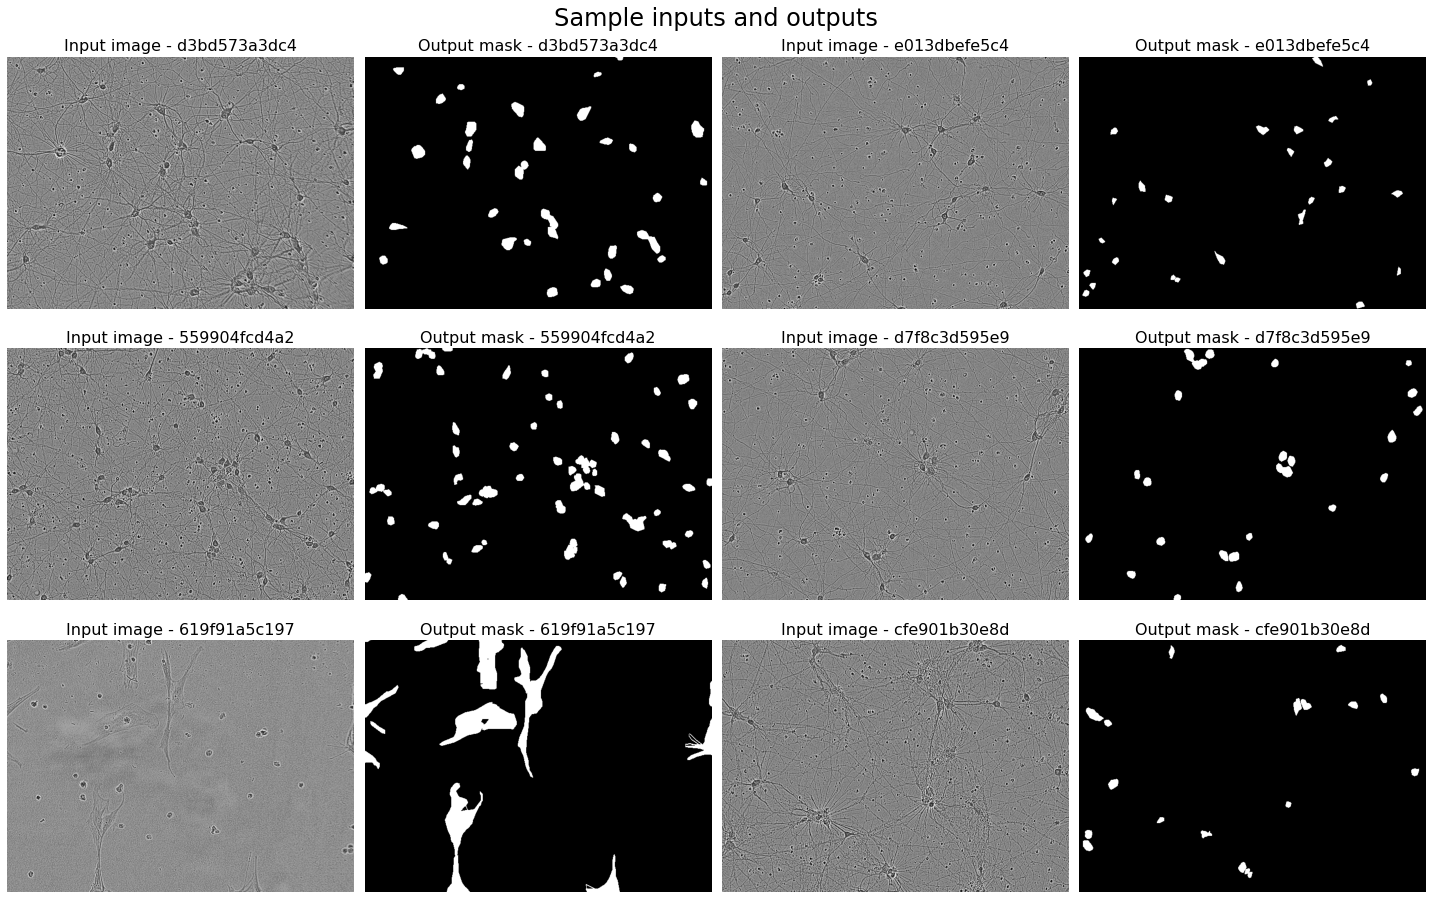

In [5]:
image_ids = list(train_data.keys())

plt.figure(figsize = (20 , 13))

for idx_cnt, idx_rnd_image in enumerate(np.random.randint(len(image_ids), size = 6)):
    plt.subplot(3, 4, (idx_cnt * 2) + 1)
    plt.imshow(X[idx_rnd_image], cmap = 'gray')
    plt.title(f'Input image - {image_ids[idx_rnd_image]}', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(3, 4, (idx_cnt * 2) + 2)
    plt.imshow(y[idx_rnd_image], cmap = 'gray')
    plt.title(f'Output mask - {image_ids[idx_rnd_image]}', fontsize = 16)
    plt.axis("off")
    
plt.suptitle("Sample inputs and outputs", fontsize = 24)
plt.tight_layout()
plt.show()

In [6]:
model=unet_model((cfg.preprocessing.OUTPUT_SHAPE.HEIGHT, cfg.preprocessing.OUTPUT_SHAPE.WIDTH, 1))
model.compile(optimizer = Adam(cfg.training.model.LEARNING_RATE), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

2022-02-19 12:48:37.863442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-02-19 12:48:37.863474: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-19 12:48:37.863492: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-02-19 12:48:37.863638: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Model: "Sartorius"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 512, 704, 1) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 512, 704, 16) 416         Input_Layer[0][0]                
__________________________________________________________________________________________________
Max_Pool_1 (MaxPooling2D)       (None, 256, 352, 16) 0           Conv_1[0][0]                     
__________________________________________________________________________________________________
SPD_1 (SpatialDropout2D)        (None, 256, 352, 16) 0           Max_Pool_1[0][0]                 
__________________________________________________________________________________________

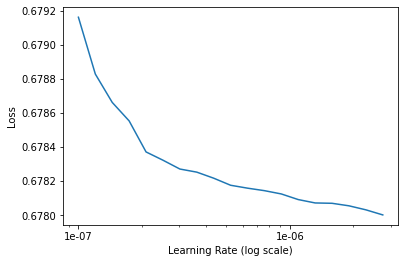

In [14]:
# cache old model weights before

lr_finder = LRFinder()
with tf.device(f'/device:GPU:{cfg.training.device.GPU}'):
    _ = model.fit(X, y, callbacks=[lr_finder], verbose=False)
lr_finder.plot()